In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.optim as optim
import time


# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(file_path):
    # 데이터 로드
    data = pd.read_csv(file_path)

    # 입력 데이터(X)와 타겟(y) 분리
    X = data.drop(["ID", "label"], axis=1)
    y = np.array(data["label"])
    y = y.reshape(-1, 1)

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # 데이터 표준화
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


# 데이터 로드 및 분리
X_train, X_test, y_train, y_test = load_and_preprocess_data(
    "data/preprocessed_drives_outlier.csv"
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# TensorDataset과 DataLoader 생성 (배치 학습 적용)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2860)

In [5]:
len(test_dataset)

2860

In [6]:
import torch
import torch.nn as nn


class ChurnPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 은닉층과 배치 정규화, 드롭아웃 추가
        self.fc1 = nn.Linear(12, 128)  # 첫 번째 은닉층
        self.bn1 = nn.BatchNorm1d(128)  # 첫 번째 배치 정규화
        self.fc2 = nn.Linear(128, 64)  # 두 번째 은닉층
        self.bn2 = nn.BatchNorm1d(64)  # 두 번째 배치 정규화
        self.fc3 = nn.Linear(64, 32)  # 세 번째 은닉층
        self.bn3 = nn.BatchNorm1d(32)  # 세 번째 배치 정규화
        self.fc4 = nn.Linear(32, 1)  # 출력층

        # 활성화 함수와 드롭아웃 설정
        self.relu = nn.ReLU()  # 활성화 함수
        self.dropout = nn.Dropout(0.35)  # 드롭아웃 확률: 35%

    def forward(self, x):
        # 각 은닉층 통과 시 배치 정규화 및 드롭아웃 적용
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))  # 이진 분류를 위한 sigmoid 활성화 함수
        return x

In [7]:
# 모델, 손실 함수, 옵티마이저 및 학습률 스케줄러 정의
input_dim = X_train.shape[1]
model = ChurnPredictionModel()

criterion = nn.BCELoss()  # 이진 분류에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

# 학습률 조정 스케줄러: CosineAnnealingWarmRestarts를 사용하여 학습률을 주기적으로 리셋
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.00001)

In [ ]:
# 이상치 제거 X
save_path = "model/dl_model.pth"  # 최적 모델 저장 경로

In [ ]:
# 이상치 제거
save_path = "model/dl_model_outlier.pth"  # 최적 모델 저장 경로

In [ ]:
# 초기화
num_epochs = 100
best_score = torch.inf  # 성능 개선 기준 초기값
patience = 20  # 조기 종료를 위한 patience 값
trigger_count = 0  # 개선이 없을 때 증가하는 카운트

# 손실과 정확도 기록용 리스트 초기화
train_losses = []
valid_losses = []
valid_acces = []

s = time.time()  # 학습 시작 시간 기록
# 모델 학습
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_predictions = 0  # 정확도 계산을 위한 초기화
    total_predictions = 0  # 총 예측 개수 초기화

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        pred_train = model(X_batch)
        # 손실 계산 및 역전파
        loss = criterion(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
    # 에포크 평균 손실 계산
    avg_loss = train_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    valid_loss = valid_acc = 0.0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            pred_test = model(X_test)  # positive일 확률
            valid_loss += criterion(pred_test, y_test).item()
            #  이진 분류에서 accuracy
            valid_acc += torch.sum((pred_test > 0.5).type(torch.int32) == y_test).item()
        valid_loss /= len(test_loader)
        valid_acc /= len(test_loader.dataset)
        valid_losses.append(valid_loss)
        valid_acces.append(valid_acc)

    # Best Score 업데이트 및 조기 종료 체크
    if valid_loss < best_score:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss Improved from {best_score:.4f} to {valid_loss:.4f}. Saving Model."
        )
        best_score = valid_loss
        torch.save(model, save_path)
        trigger_count = 0  # 성능 개선 시 초기화
    else:
        trigger_count += 1
        if trigger_count >= patience:
            print(
                f"Early stopping at epoch {epoch+1}. No improvement for {patience} epochs."
            )
            break

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
    )

e = time.time()
training_time = e - s
print(f"\nTotal Training Time: {training_time:.2f} seconds")

Epoch [1/100], Loss Improved from inf to 0.4317. Saving Model.
Epoch [1/100], Train Loss: 0.5568, Valid Loss: 0.4317, Valid Acc: 0.8168
Epoch [2/100], Loss Improved from 0.4317 to 0.4139. Saving Model.
Epoch [2/100], Train Loss: 0.4311, Valid Loss: 0.4139, Valid Acc: 0.8238
Epoch [3/100], Loss Improved from 0.4139 to 0.4113. Saving Model.
Epoch [3/100], Train Loss: 0.4262, Valid Loss: 0.4113, Valid Acc: 0.8227
Epoch [4/100], Loss Improved from 0.4113 to 0.4096. Saving Model.
Epoch [4/100], Train Loss: 0.4208, Valid Loss: 0.4096, Valid Acc: 0.8227
Epoch [5/100], Train Loss: 0.4205, Valid Loss: 0.4108, Valid Acc: 0.8227
Epoch [6/100], Train Loss: 0.4186, Valid Loss: 0.4103, Valid Acc: 0.8227
Epoch [7/100], Train Loss: 0.4194, Valid Loss: 0.4102, Valid Acc: 0.8227
Epoch [8/100], Train Loss: 0.4176, Valid Loss: 0.4114, Valid Acc: 0.8227
Epoch [9/100], Train Loss: 0.4148, Valid Loss: 0.4097, Valid Acc: 0.8227
Epoch [10/100], Train Loss: 0.4132, Valid Loss: 0.4097, Valid Acc: 0.8227
Epoch [1

In [12]:
# load best model
best_model = torch.load(save_path)
best_model.eval()

# 모델 평가
y_pred_list = []
y_prob_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        prob_test = model(X_batch)  # positive일 확률
        pred_test = prob_test.round()
        valid_acc += torch.sum((pred_test > 0.5).type(torch.int32) == y_batch).item()
        y_pred_list.append(pred_test)
        y_prob_list.append(prob_test)
    y_pred_list = np.concatenate(y_pred_list)
    y_prob_list = np.concatenate(y_prob_list)

C:\Users\USER\AppData\Local\Temp\ipykernel_15088\4270272651.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(save_path)


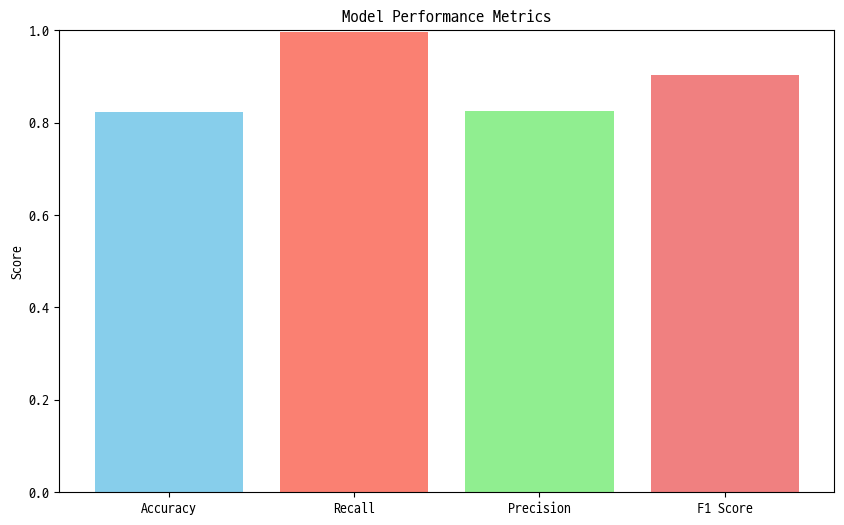

In [13]:
# 성능 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred_list)
recall = recall_score(y_test, y_pred_list)
precision = precision_score(y_test, y_pred_list)
f1 = f1_score(y_test, y_pred_list)

# 정확도, 재현율, 정밀도, F1 점수 시각화
metrics = ["Accuracy", "Recall", "Precision", "F1 Score"]
values = [accuracy, recall, precision, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=["skyblue", "salmon", "lightgreen", "lightcoral"])
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()

In [54]:
"""
데이터 로드 및 전처리: 데이터를 불러오고, 결측치를 제거한 후 타겟 값을 인코딩하고 표준화하여 학습 및 평가 데이터셋으로 분리합니다.

모델 정의:

드롭아웃을 각 은닉층에 추가하여 과적합을 방지하고, 모델의 일반화 성능을 높입니다.
ReLU 활성화 함수로 비선형성을 추가하여 복잡한 패턴을 학습할 수 있게 합니다.
옵티마이저 및 스케줄러 설정:

Adam 옵티마이저로 학습 속도를 개선하고, 자동으로 학습률을 조절합니다.
CosineAnnealingWarmRestarts를 사용하여 학습률을 점진적으로 감소시키면서 주기적으로 리셋하여, 최적점을 찾기 쉽도록 합니다.
학습 과정:

optimizer.zero_grad()로 각 배치마다 그래디언트를 초기화하고, loss.backward()로 역전파를 수행한 후 optimizer.step()으로 모델 파라미터를 업데이트합니다.
매 에포크마다 학습 손실과 정확도를 기록합니다.
scheduler.step()을 통해 매 에포크마다 학습률을 조정하여 **과적합 방지
"""

'\n데이터 로드 및 전처리: 데이터를 불러오고, 결측치를 제거한 후 타겟 값을 인코딩하고 표준화하여 학습 및 평가 데이터셋으로 분리합니다.\n\n모델 정의:\n\n드롭아웃을 각 은닉층에 추가하여 과적합을 방지하고, 모델의 일반화 성능을 높입니다.\nReLU 활성화 함수로 비선형성을 추가하여 복잡한 패턴을 학습할 수 있게 합니다.\n옵티마이저 및 스케줄러 설정:\n\nAdam 옵티마이저로 학습 속도를 개선하고, 자동으로 학습률을 조절합니다.\nCosineAnnealingWarmRestarts를 사용하여 학습률을 점진적으로 감소시키면서 주기적으로 리셋하여, 최적점을 찾기 쉽도록 합니다.\n학습 과정:\n\noptimizer.zero_grad()로 각 배치마다 그래디언트를 초기화하고, loss.backward()로 역전파를 수행한 후 optimizer.step()으로 모델 파라미터를 업데이트합니다.\n매 에포크마다 학습 손실과 정확도를 기록합니다.\nscheduler.step()을 통해 매 에포크마다 학습률을 조정하여 **과적합 방지\n'

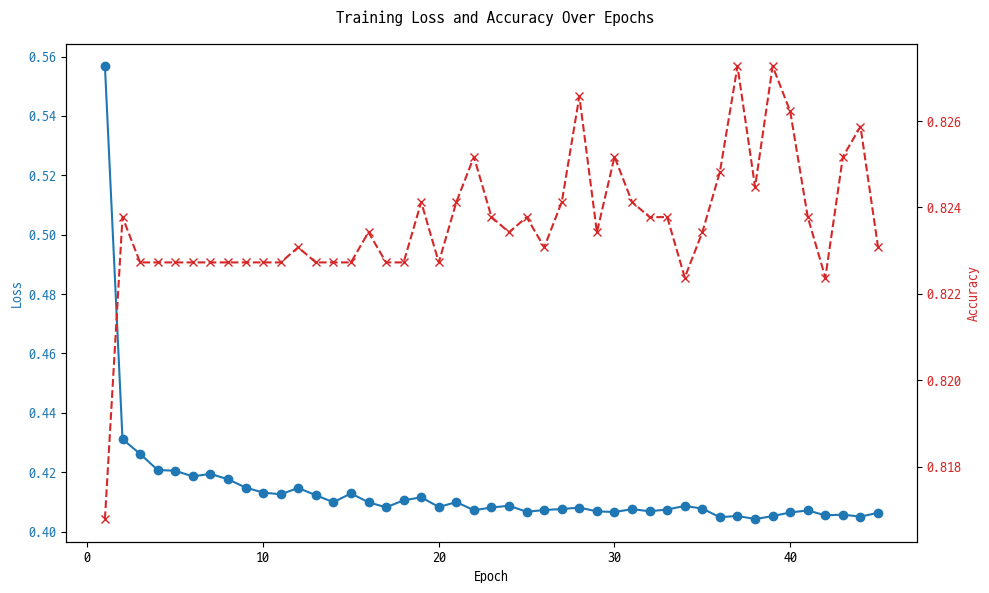

In [14]:
# 이중 y축 그래프: 학습 손실 및 정확도 변화 추세
fig, ax1 = plt.subplots(figsize=(10, 6))

# 손실 값 (왼쪽 y축)
color = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color)
ax1.plot(
    range(1, len(train_losses) + 1),
    train_losses,
    color=color,
    marker="o",
    label="Train Loss",
)
ax1.tick_params(axis="y", labelcolor=color)

# 정확도 값 (오른쪽 y축)
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Accuracy", color=color)
ax2.plot(
    range(1, len(valid_acces) + 1),
    valid_acces,
    color=color,
    marker="x",
    linestyle="--",
    label="valid Accuracy",
)
ax2.tick_params(axis="y", labelcolor=color)

fig.suptitle("Training Loss and Accuracy Over Epochs")
fig.tight_layout()
plt.show()

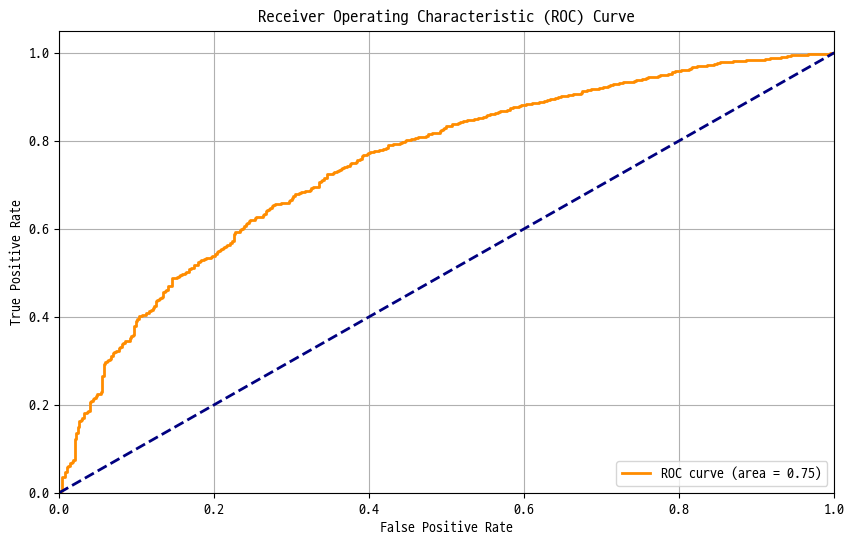

In [15]:
# ROC 곡선 및 AUC 계산
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob_list)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

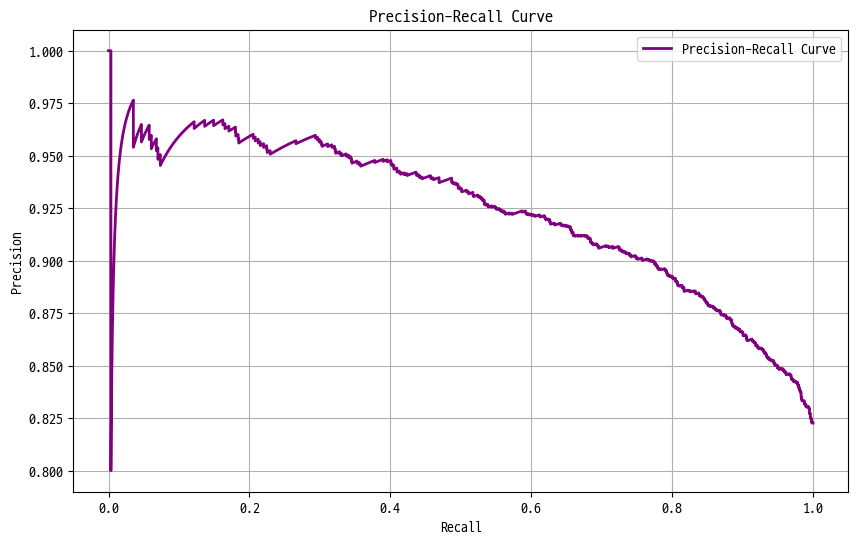

In [16]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall 곡선
precision, recall, _ = precision_recall_curve(y_test, y_prob_list)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color="purple", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid()
plt.show()

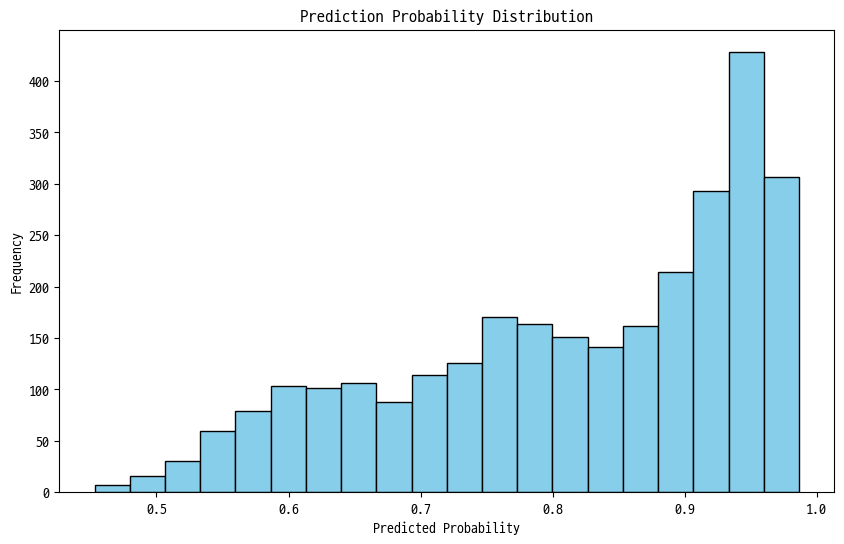

In [17]:
# 예측 확률 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(y_prob_list, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Prediction Probability Distribution")
plt.show()

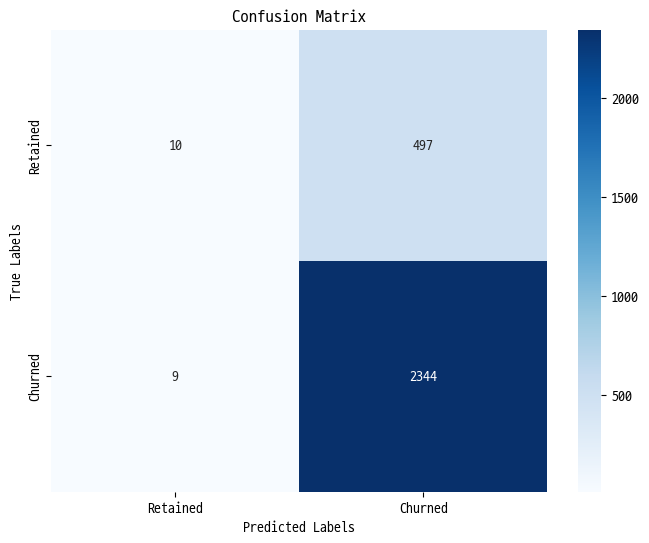

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred_list)

# 히트맵으로 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Retained", "Churned"],
    yticklabels=["Retained", "Churned"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [62]:
"""
sessions
사용자가 한 달 동안 앱을 연 횟수입니다. 일반적으로 세션 수가 적을수록 이탈률이 높게 나타날 가능성이 큽니다. 세션 수가 늘어나면 앱에 대한 관심과 사용 필요도가 높다는 뜻이므로, 이탈률이 낮아지는 경향이 있습니다.

drives
한 달 동안 최소 1km 이상 주행한 횟수를 나타냅니다. 드라이브 횟수가 적은 사용자는 앱을 자주 사용하지 않으므로 이탈률이 높아질 수 있습니다. 반면, 드라이브 횟수가 증가하면 앱 사용도가 높아지며, 이탈률은 낮아지는 경향이 보일 수 있습니다.

total_sessions
사용자가 가입 이후 실행한 총 세션 수입니다. 총 세션 수가 많을수록 사용자가 앱을 자주 사용했음을 의미하며, 이탈률이 낮아질 가능성이 큽니다.

n_days_after_onboarding
가입 이후 지난 일 수를 나타냅니다. 이 값이 작을수록 신규 사용자일 가능성이 높습니다. 일반적으로 신규 사용자는 앱 사용 초기의 경험이 만족스럽지 않으면 쉽게 이탈할 수 있으므로, 이 값이 작을수록 이탈률이 높을 수 있습니다.

total_navigations_fav1 및 total_navigations_fav2
사용자가 즐겨찾는 장소 1과 2로의 총 네비게이션 횟수입니다. 이 값이 높을수록 사용자가 특정 장소를 자주 찾는 경향을 보이며, 앱의 필요성이 커지므로 이탈률이 낮아질 가능성이 있습니다.

driven_km_drives
한 달 동안 총 주행 거리(km)입니다. 주행 거리가 길수록 사용자가 운전에 더 의존하며, 네비게이션이 필요할 가능성이 커져 이탈률이 낮아질 수 있습니다.

duration_minutes_drives
한 달 동안 총 운전 시간(분)입니다. 운전 시간이 길수록 사용자가 앱을 자주 사용하며 이탈률이 낮아질 가능성이 큽니다.

activity_days
사용자가 한 달 동안 앱을 실행한 총 일 수입니다. 이 값이 높을수록 앱 사용 빈도가 높아져 이탈률이 낮아질 수 있습니다.

driving_days
한 달 동안 최소 1km 이상 운전한 날 수입니다. 운전한 날이 많을수록 앱 사용 필요성이 커지며, 이탈률은 낮아지는 경향을 보일 수 있습니다.
"""

'\nsessions\n사용자가 한 달 동안 앱을 연 횟수입니다. 일반적으로 세션 수가 적을수록 이탈률이 높게 나타날 가능성이 큽니다. 세션 수가 늘어나면 앱에 대한 관심과 사용 필요도가 높다는 뜻이므로, 이탈률이 낮아지는 경향이 있습니다.\n\ndrives\n한 달 동안 최소 1km 이상 주행한 횟수를 나타냅니다. 드라이브 횟수가 적은 사용자는 앱을 자주 사용하지 않으므로 이탈률이 높아질 수 있습니다. 반면, 드라이브 횟수가 증가하면 앱 사용도가 높아지며, 이탈률은 낮아지는 경향이 보일 수 있습니다.\n\ntotal_sessions\n사용자가 가입 이후 실행한 총 세션 수입니다. 총 세션 수가 많을수록 사용자가 앱을 자주 사용했음을 의미하며, 이탈률이 낮아질 가능성이 큽니다.\n\nn_days_after_onboarding\n가입 이후 지난 일 수를 나타냅니다. 이 값이 작을수록 신규 사용자일 가능성이 높습니다. 일반적으로 신규 사용자는 앱 사용 초기의 경험이 만족스럽지 않으면 쉽게 이탈할 수 있으므로, 이 값이 작을수록 이탈률이 높을 수 있습니다.\n\ntotal_navigations_fav1 및 total_navigations_fav2\n사용자가 즐겨찾는 장소 1과 2로의 총 네비게이션 횟수입니다. 이 값이 높을수록 사용자가 특정 장소를 자주 찾는 경향을 보이며, 앱의 필요성이 커지므로 이탈률이 낮아질 가능성이 있습니다.\n\ndriven_km_drives\n한 달 동안 총 주행 거리(km)입니다. 주행 거리가 길수록 사용자가 운전에 더 의존하며, 네비게이션이 필요할 가능성이 커져 이탈률이 낮아질 수 있습니다.\n\nduration_minutes_drives\n한 달 동안 총 운전 시간(분)입니다. 운전 시간이 길수록 사용자가 앱을 자주 사용하며 이탈률이 낮아질 가능성이 큽니다.\n\nactivity_days\n사용자가 한 달 동안 앱을 실행한 총 일 수입니다. 이 값이 높을수록 앱 사용 빈도가 높아져 이탈률이 낮아질 수 있습니다.\n\ndriving_d